In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets
import transformers
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
device = torch.device("mps")
from sklearn.metrics import f1_score,accuracy_score

In [4]:
df = pd.read_csv('new_train.csv',index_col=0)

In [5]:
df.head()

,text,label
0,"<prompt>[""Is it morally right to try to have a...",1
1,"<prompt>[""What is the difference between marri...",2
2,"<prompt>[""explain function calling. how would ...",0
3,"<prompt>[""How can I create a test set for a ve...",1
4,"<prompt>[""What is the best way to travel from ...",2


In [6]:
df['wrd_len'] = df['text'].str.split().apply(len)

In [10]:
df['wrd_len'].quantile(0.75)

590.0

<Axes: xlabel='label', ylabel='count'>

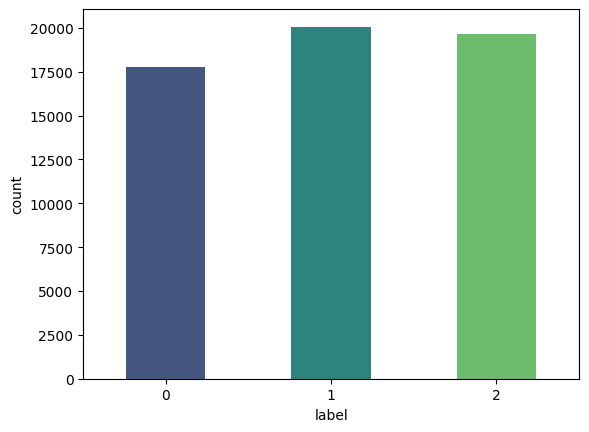

In [13]:
sns.countplot(x='label',data=df,palette='viridis',gap=0.4)

In [17]:
from datasets import load_dataset, Features, Value

# Define a schema that matches your CSV file
features = Features({
    "Unnamed: 0": Value("int64"), 
    "text": Value("string"), 
    "label": Value("int64")
})

# Load the dataset using your custom schema
dataset = load_dataset('csv', data_files='new_train.csv', features=features)

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
dataset = dataset.remove_columns('Unnamed: 0')

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 57477
    })
})

In [22]:
model_ckpt = 'distilbert-base-uncased'

In [23]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [24]:
def apply_tokenizer(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [26]:
dataset_encoded = dataset.map(apply_tokenizer,batched=True,batch_size=None)

Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

In [27]:
dataset_encoded.set_format("pt",columns=['input_ids','attention_mask','label'])

In [31]:
dataset_encoded = dataset_encoded['train'].train_test_split(train_size=0.85)

In [32]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 39083
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6898
    })
})

In [36]:
from transformers import AutoModelForSequenceClassification
num_labels = 3
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels,).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}

In [41]:
from transformers import TrainingArguments
new_model='LLM_PROMPTS_CLASSIFICATION'
batch_size=4
logging_steps = len(dataset_encoded['train'])//batch_size
num_train_epochs = 4
training_args = TrainingArguments(output_dir=new_model,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 log_level="error",
                                 logging_steps=logging_steps,
                                 eval_strategy="epoch",
                                 disable_tqdm=False,
                                 weight_decay=0.01,
                                 learning_rate=2e-5,
                                 push_to_hub=False)

In [42]:
from transformers import Trainer
trainer = Trainer(model=model,
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=dataset_encoded['train'],
                 eval_dataset=dataset_encoded['test'],
                 tokenizer=tokenizer)

In [43]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 